# Clique Graph Kernel
In this notebook, we will explore connection between cliques in graphs and the modular product of graphs. This will lead us to develop a graph kernel based on clique counting.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from grakel.kernels import ShortestPath, WeisfeilerLehman
from grakel.utils import graph_from_networkx

from product import modular_product
from visual import plot_graph, plot_horizontally
from data import MUTAG
from clique_kernel import CliqueKernel

/home/mseeliger/miniconda3/envs/clique-kernel/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Modular Product of Graphs
The modular product of two graphs is a concept in graph theory that involves combining two graphs, G and H, into a single graph. This product has specific applications, particularly in subgraph isomorphism problems. The construction of the modular product graph follows this definition:

### Definition
The vertex set of the modular product is the Cartesian product of the vertex sets of the two graphs. For any two vertices $(u, v)$ and $(u', v')$ in the modular product, there is an edge between them if and only if $u$ is different from $u'$ and $v$ is different from $v'$ and either:
- **Cond. 1**: $u$ and $u'$ are adjacent in the first graph and $v$ and $v'$ are adjacent in the second graph, or
- **Cond. 2**: $u$ and $u'$ are not adjacent in the first graph and $v$ and $v'$ are not adjacent in the second graph.

$$
\text{Modular}(G, H) = (V_{\text{mod}}, E_{\text{mod}}) \\
V_{\text{mod}} = V_G \times V_H \\
E_{\text{mod}} = \{((u, v), (u', v')) \in V_{\text{mod}} \times V_{\text{mod}} \,|\, u \neq u', v \neq v', \\
((u, u') \in E_G \wedge (v, v') \in E_H) \vee ((u, u') \notin E_G \wedge (v, v') \notin E_H)\}
$$

### Application
The modular product of two graphs transforms the subgraph isomorphism problem into clique-finding problem. The construction of the modular product allows the equality of the existence of a clique with the isomorphism of the induced subgraphs (from the nodes contained in the clique) of $G$ and $H$.

### Example
Let's look at an example of the modular product of two graphs. We will use the following two graphs:
- $P_3$, the path graph on 3 nodes
- $K_3$, the complete graph on 3 nodes

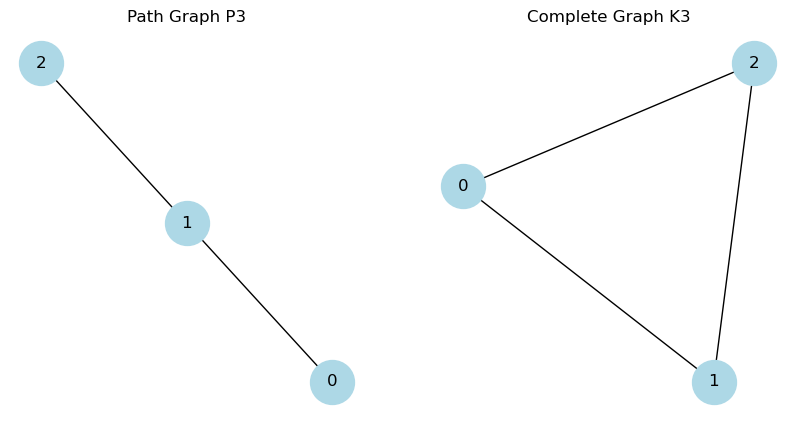

In [2]:
P3 = nx.path_graph(3)
K3 = nx.complete_graph(3)

plot_horizontally([P3, K3], ["Path Graph P3", "Complete Graph K3"])

Now after applying the modular product, we get the following graph:

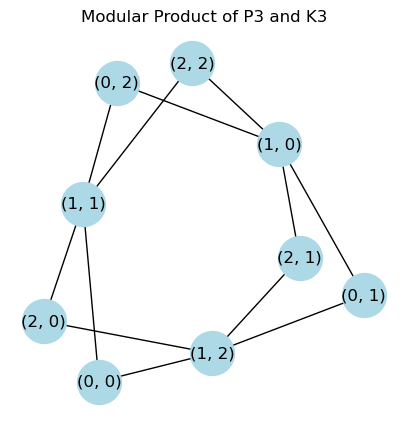

In [3]:
P3_K3 = modular_product(P3, K3)

pos = nx.spring_layout(P3_K3, seed=41)

plot_graph(P3_K3, pos=pos, title="Modular Product of P3 and K3")

Observing the resulting graph we see a strong similarity with the tensor product

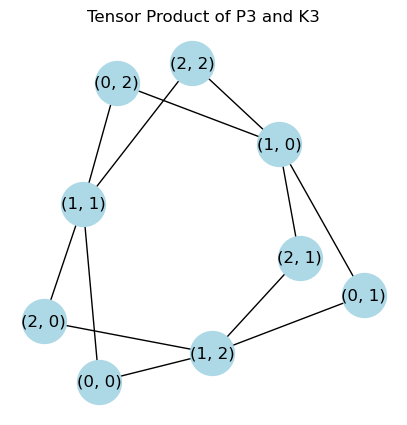

In [4]:
P3_K3_tensor = nx.tensor_product(P3, K3)

plot_graph(P3_K3_tensor, pos=pos, title="Tensor Product of P3 and K3")

Thinking about this further, it is not surprising. More generally we can see that the modular product is equal to the tensor product, if one of the graph factors is a complete graph. This is because the **Cond 2.** is always false, since all nodes are adjacent in the complete graph. This means that nodes in the product all result from the first rule, which is corresponding to the definition of the tensor product.

Let's look at another example, where we use the following two graphs:
- $P_3$, the path graph on 3 nodes
- $C_4$, the cycle graph on 4 nodes

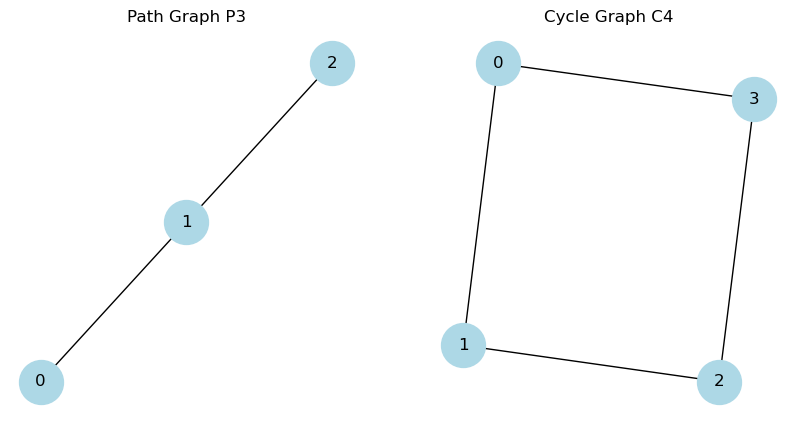

In [5]:
C4 = nx.cycle_graph(4)

plot_horizontally([P3, C4], ["Path Graph P3", "Cycle Graph C4"])

Again we will compute the modular product of these two graphs:

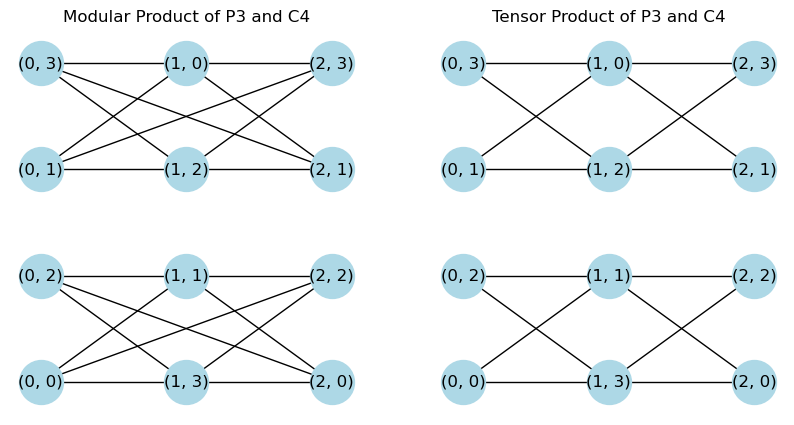

In [6]:
P3_C4 = modular_product(P3, C4)
P3_C4_tensor = nx.tensor_product(P3, C4)

# The following code is to point out the separate components
pos = {}
for i in range(3):
    for j in range(4):
        even_col_transform = [idx for idx in range(4) if idx % 2 == 0] + [idx for idx in range(4) if idx % 2 == 1]
        odd_col_transform = even_col_transform[::-1]
        if i % 2 == 0:
            pos[(i, j)] = (i, even_col_transform[j])
        else:
            pos[(i, j)] = (i, odd_col_transform[j])

plot_horizontally([P3_C4, P3_C4_tensor], 
                  ["Modular Product of P3 and C4", "Tensor Product of P3 and C4"], 
                  pos=pos)

## Clique Graph Kernel
Now that we have seen the connection between cliques and the modular product of graphs, we can use this to develop a graph kernel based on clique counting. The idea is to count the number of cliques of size $k$ in the modular product of two graphs. This is equivalent to counting the number of induced subgraphs of size $k$ in the two graphs that are isomorphic. Alternatively, it is also possible to take cliques of all sizes into account. This is equivalent to counting the number of induced subgraphs in the two graphs that are isomorphic.

In [7]:
def evaluate_kernel(kernel, graphs, y):
    G_train, G_test, y_train, y_test = train_test_split(graphs, y, test_size=0.2)

    print("Computing the kernel matrix...", flush=True)
    K = kernel.fit_transform(G_train)
    print("done")

    print("Training the SVM...", flush=True)
    svm = SVC(kernel="precomputed")

    param_grid = {
        "C": np.logspace(-5, 5, 150)
    }

    clf = RandomizedSearchCV(svm, param_grid, n_iter=50, cv=3, verbose=1, n_jobs=-1)
    clf.fit(K, y_train)
    print("done")

    print("Evaluating the model...", flush=True)
    K_test = kernel.transform(G_test)
    y_pred = clf.predict(K_test)
    print("done")

    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()


### Data
We will use the MUTAG dataset, which contains 188 graphs of chemical compounds with 7 discrete node labels and 2 discrete edge labels. The task is to classify the graphs into two classes, which are mutagenic or non-mutagenic.

In [8]:
G, y = MUTAG()

Extracting /tmp/MUTAG/MUTAG/MUTAG.zip
Processing...
Done!


## Experiments
We will now check how well the clique graph kernel performs on the MUTAG dataset. We will compare different values for $k$ and also compare the results with the Weisfeiler-Lehman subtree kernel and the shortest-path kernel.

Computing the kernel matrix...


Processing: 100%|██████████| 11325/11325 [1:13:58<00:00,  2.55it/s]

done
Training the SVM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


done
Evaluating the model...


Processing: 100%|██████████| 5700/5700 [35:13<00:00,  2.70it/s]


done
              precision    recall  f1-score   support

           0       0.25      0.22      0.24         9
           1       0.77      0.79      0.78        29

    accuracy                           0.66        38
   macro avg       0.51      0.51      0.51        38
weighted avg       0.64      0.66      0.65        38



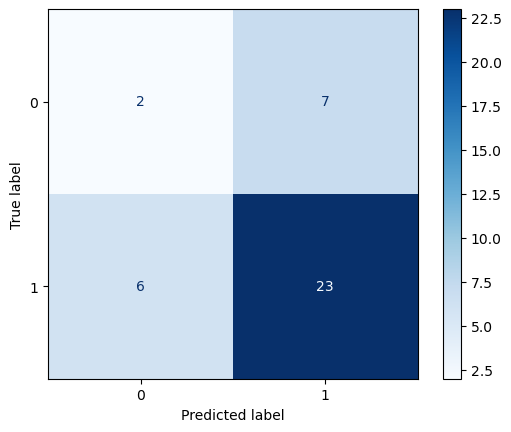

In [9]:
kernel = CliqueKernel(k=3, normalize=True)
evaluate_kernel(kernel, G, y)

Computing the kernel matrix...


Processing: 100%|██████████| 11325/11325 [1:18:09<00:00,  2.41it/s]

done
Training the SVM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


done
Evaluating the model...


Processing: 100%|██████████| 5700/5700 [36:01<00:00,  2.64it/s]


done
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.66      1.00      0.79        25

    accuracy                           0.66        38
   macro avg       0.33      0.50      0.40        38
weighted avg       0.43      0.66      0.52        38



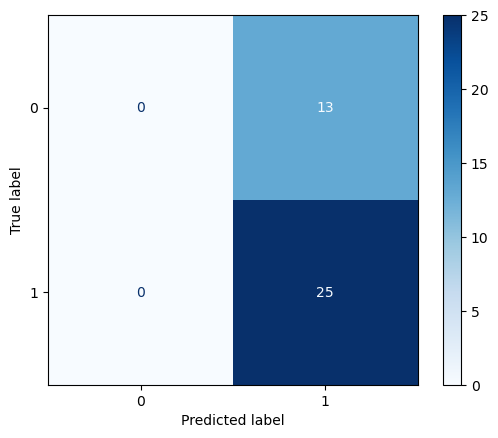

In [10]:
kernel = CliqueKernel(k=5, normalize=True)
evaluate_kernel(kernel, G, y)

Computing the kernel matrix...


Processing: 100%|██████████| 11325/11325 [3:21:07<00:00,  1.07s/it]

done
Training the SVM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


done
Evaluating the model...


Processing: 100%|██████████| 5700/5700 [1:56:56<00:00,  1.23s/it]


done
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.74      0.85      0.79        27

    accuracy                           0.68        38
   macro avg       0.59      0.56      0.56        38
weighted avg       0.65      0.68      0.66        38



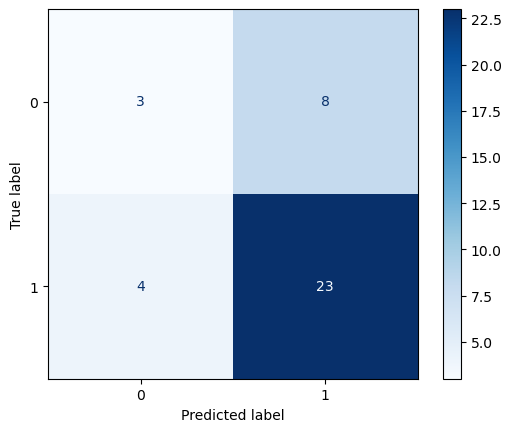

In [11]:
kernel = CliqueKernel(k=None, normalize=True)
evaluate_kernel(kernel, G, y)

For the comparative methods, we will use the implementations from the `grakel` package. Therefore, we will first need to convert the MUTAG dataset into the format used by the package.

In [12]:
grakel_G = list(graph_from_networkx(G, node_labels_tag="x"))

Computing the kernel matrix...
done
Training the SVM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
done
Evaluating the model...
done
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.86      0.96      0.91        25

    accuracy                           0.87        38
   macro avg       0.88      0.83      0.84        38
weighted avg       0.87      0.87      0.86        38



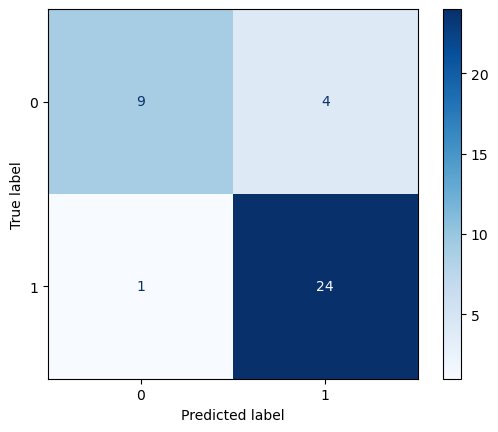

In [13]:
kernel = ShortestPath(normalize=True)
evaluate_kernel(kernel, grakel_G, y)

Computing the kernel matrix...
done
Training the SVM...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
done
Evaluating the model...
done
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        28

    accuracy                           0.89        38
   macro avg       0.86      0.86      0.86        38
weighted avg       0.89      0.89      0.89        38



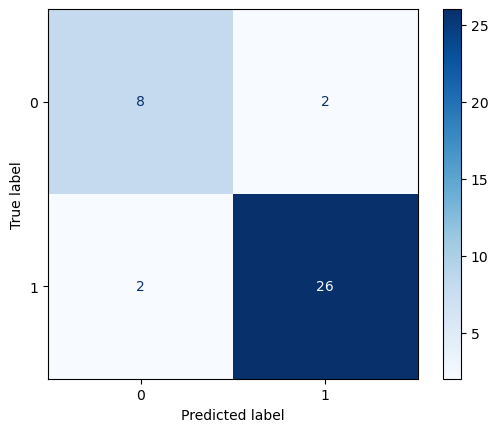

In [14]:
kernel = WeisfeilerLehman(n_iter=5, normalize=True)
evaluate_kernel(kernel, grakel_G, y)